# The following cell is the model class. 
Its __call__ method returns the predicted FPS according to aformentioned formula.
Its load_variables method loads previously trained parameters which will be used by the __call__ method to make predictions.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class layer():
    def __init__(self,shape=None,activation=None):
        self.shape=shape
        self.activation=activation

In [3]:
class train_action():
    def __init__(self):
        
        # define all the metric loss functions
        self.losses={'binary_crossentropy':tf.keras.losses.binary_crossentropy,
          'MSE': tf.keras.losses.MSE,'CategoricalCrossentropy':tf.keras.losses.CategoricalCrossentropy}
        
    ## uses tensorflow to do backpropagation onece for each epoch.
    def train_one_step(self,X,Y):
        with tf.GradientTape() as tape:
            predict = self.predict(X)
            loss=self.compute_loss(predict, Y)
            optimizer=self.optimizer
            # compute gradient
            grads = tape.gradient(loss, self.trainable_variables)
            # update to weights
            optimizer.apply_gradients(zip(grads, self.trainable_variables))   
        
     
    def compute_loss(self,predict, Y):       
        return self.losses[self.loss](predict,Y)
    
    def save_model(self,filename):
        stored_variables=np.array([i.numpy() for i in self.trainable_variables])
        np.save(filename, stored_variables,allow_pickle=True, fix_imports=True)
        print('model has been saved')

In [4]:
## shape is a list of tuples.
## The i_th element represents the tensor structure of the i_th layer.
## The 0_th element represents the shape of the input.
## The -1_th element represents the shape of the output.
class sequential(train_action):
    
    def __init__(self,layers):       
        super().__init__()
        
        ## attribute cannot be a function but can be a dictionary of functions.
        self.activations={'relu':tf.keras.activations.relu,'elu':tf.keras.activations.elu,\
            'sigmoid':tf.keras.activations.sigmoid, 'selu': tf.keras.activations.selu}

        
        self.layers=layers
        self.weights=[]
        self.bias=[]
        self.trainable_variables=[]

        for i in range(len(layers)-1):
            weight=tf.Variable(tf.random.truncated_normal(shape=self.layers[i].shape+self.layers[i+1].shape))
            bias=tf.Variable(tf.zeros(shape=self.layers[i+1].shape))
            self.weights.append(weight) 
            self.bias.append(bias) 
        self.trainable_variables=self.weights+self.bias
        
    def predict(self,X=None):
        X=tf.cast(X,tf.float32)
        Y=X
        for i in range(0,len(self.layers)-1): #i is the layer we are right now and the
                                              # data will propagate to the next layer
                                              # so the we should use the activation function in the next layer 
            
            # the shape of current layer, the first one is the batch size
            backdim=self.layers[i].shape 
            
            # the shape of next layer
            frontdim=self.layers[i+1].shape      
            bl=len(backdim)
            
            
            Y=tf.tensordot(Y,self.weights[i],\
                           axes=[np.arange(1,bl+1),np.arange(0,bl)])+self.bias[i]
            if self.layers[i+1].activation:
                Y=self.activations[self.layers[i+1].activation](Y)
             


        return Y
    
    def compile(self,loss=None,optimizer=None):
        # loss is string name of the tf.keras.losses functions
        # optimizer is a class for most cases in tensorflow, so the optimizer here is a class
        self.loss=loss
        self.optimizer=optimizer
        
    def train(self,X,Y,epochs=10,save_name=None):
        
        for epoch in range(epochs): 
            predict=self.predict(X)
            print('for epoch {}, {} is {}'.format(epoch,self.loss,self.compute_loss(predict,Y)))
            self.train_one_step(X,Y)  
        if save_name:
            self.save_model(save_name)
        
    

In [5]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [6]:
X_train=X_train[:5000]/255.0

In [7]:
layers=[layer(shape=(28,28)),layer(shape=(100,),activation='selu'),\
        layer(shape=(30,),activation='selu'),layer(shape=(100,),activation='selu'),
       layer(shape=(28,28),activation='sigmoid')]

In [8]:
testmodel=model(layers)

In [9]:
testmodel.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.SGD(lr=1.5))

In [10]:
testmodel.train(X_train,X_train,epochs=10,save_name='weights_bias')

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
for epoch 0, binary_crossentropy is [[7.16158322 7.7124742  7.82566197 ... 4.02388295 6.61069225 8.26336525]
 [4.8000676  5.80673284 3.57289538 ... 3.9040786  3.94918877 4.40642572]
 [6.74377552 5.50610165 5.95917835 ... 4.67402195 4.20270205 6.88095243]
 ...
 [8.26336525 6.6106922  6.6106922  ... 4.40712813 6.6106922  8.82293148]
 [7.16158322 5.50891051 4.40712813 ... 5.50891017 5.50891017 7.71207387]
 [5.77879705 8.37136913 5.60643925 ... 6.36359746 4.27308582 6.05089078]]
for epoch 1, binary_crossentropy is [[1.10178203 2.20356407 1.10178203 ... 0.10501928 2.20356407 0.55089102]
 [1.27889086 2.98592607 1.56608935 ... 0.70428944 1.50094575 0.33559257]
 [1.15399524 1.50860897 1.4934998  ... 0.20415442 1.28478539 0.23090227]
 ...
 [1.10178203 2.20356407 1.10178203 ... 0.55089102 2.20356407 0.55089102]
 [1.10178203 2.20356407 1.10178203 ... 0.55089102 2.20356407 0.550891

In [11]:
X_predict=testmodel.predict(X_train)

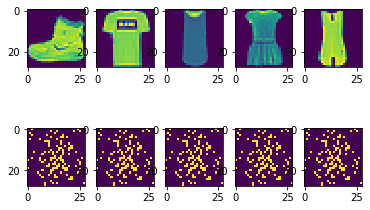

In [12]:
figure,ax=plt.subplots(2,5)
for i in range(5):
    ax[0][i].imshow(X_train[i])
for i in range(5):
    ax[1][i].imshow(X_predict[i])